# Regressão Linear com PyTorch

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se 
- o cálculo do gradiente automático do PyTorch, porém 
- a função de perda e 
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

## Importação dos pacotes

In [1]:
%matplotlib inline
#import torch
#from torch import nn, optim
#from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

np.random.seed(1234)

## Leitura dos dados

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1]
y_train = data[:,1:2]

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float64
y_train.shape: (50, 1) float64
x_train[:5]:
 [[ 7. ]
 [ 6.4]
 [ 6.9]
 [ 5.5]
 [ 6.5]]
y_train[:5]:
 [[ 4.7]
 [ 4.5]
 [ 4.9]
 [ 4. ]
 [ 4.6]]


## Normalização dos dados

In [3]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [4]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

# Linear Regression Model

In [82]:
class Net():
    def __init__(self, weight):
        self.weight = weight
    
    def __call__(self, x_bias):
        return x_bias.dot(self.weight.T)

## Inicialização dos parâmetros

In [96]:
weight = np.zeros((1,2))
#weight = np.random.uniform(-0.1,0.1,(1,2))
weight

array([[ 0.,  0.]])

In [97]:
net = Net(weight)

## Testando o predict da rede

In [100]:
net(np.ones((4,2)))

array([[ 0.81850961],
       [ 0.81850961],
       [ 0.81850961],
       [ 0.81850961]])

## Treinamento

In [101]:
num_epochs = 10
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = x_train_bias
    target = y_train

    # forward - predict
    out = net(inputs)

    #loss cálculo da função de perda
    loss = np.square(out - y_train).mean()
    
    # cálculo do gradiente pelas derivadas parciais
    weight_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(net.weight.T) - y_train)
    
    # gradiente descendente
    net.weight = net.weight - learning_rate * weight_grad.T
    
    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

## Predict

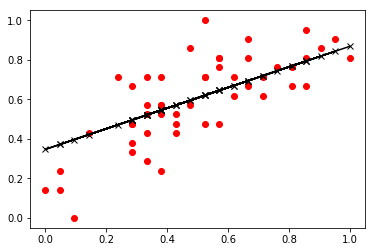

In [102]:
y_pred = net(x_train_bias)
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, y_pred, 'kx-', label='Fitting Line')
plt.show()

## Parâmetro aprendido

In [103]:
print(net.weight)

[[ 0.34697547  0.5210739 ]]


## Valor ótimo, solução analítica

In [106]:
x_bias = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)
print(w_opt.T)

[[ 0.26134159  0.68646976]]
